# Preprocessing

> ...

In [1]:
#| default_exp preprocessing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| export
from pathlib import Path
from tqdm import tqdm
import fastcore.all as fc

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d


In [4]:
#|eval: false
from lssm.loading import load_ossl
from lssm.visualization import plot_spectra
from sklearn.pipeline import Pipeline

## Scikit-learn transformers

In [5]:
#| export
class ToAbsorbance(BaseEstimator, TransformerMixin):
    """Transform Reflectance to Absorbance"""
    def __init__(self, eps=1e-5): self.eps = eps
    def fit(self, X, y=None): return self
    def transform(self, X, y=None): 
        X[X < 0] = 0
        return -np.log10(X + self.eps)

Example: 

In [6]:
#|eval: false
analytes = 'k.ext_usda.a725_cmolc.kg'
data = load_ossl(analytes, spectra_type='visnir')
X, y, X_names, smp_idx, ds_name, ds_label = data

Reading & selecting data ...


<Figure size 640x480 with 0 Axes>

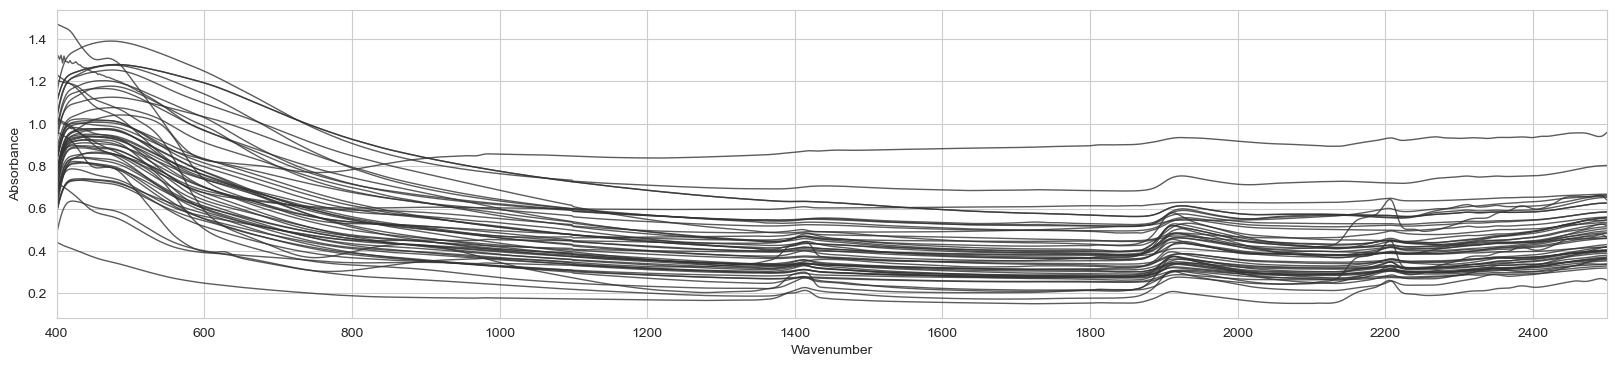

In [7]:
#|eval: false
plot_spectra(ToAbsorbance().fit_transform(X), X_names)

In [8]:
#| export
class ContinuumRemoval(BaseEstimator, TransformerMixin):
    """Creates continnum removal custom transformer"""

    def __init__(self, wls):
        fc.store_attr()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        continuum_removed_spectra = np.zeros_like(X)
        
        for i, spectrum in enumerate(tqdm(X)):
            points = np.c_[self.wls, spectrum]
            x, y = points.T 
            # trick to exclude lower part of convex hull 
            augmented = np.concatenate([points, [(x[0], np.max(y)+1), (x[-1], np.max(y)+1)]], axis=0)
            hull = ConvexHull(augmented)
            continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
            continuum_function = interp1d(*continuum_points.T)
            continuum_removed_spectra[i, :] = y / continuum_function(x)
    
        return continuum_removed_spectra

Example:

100%|██████████| 44489/44489 [00:16<00:00, 2724.09it/s]


<Figure size 640x480 with 0 Axes>

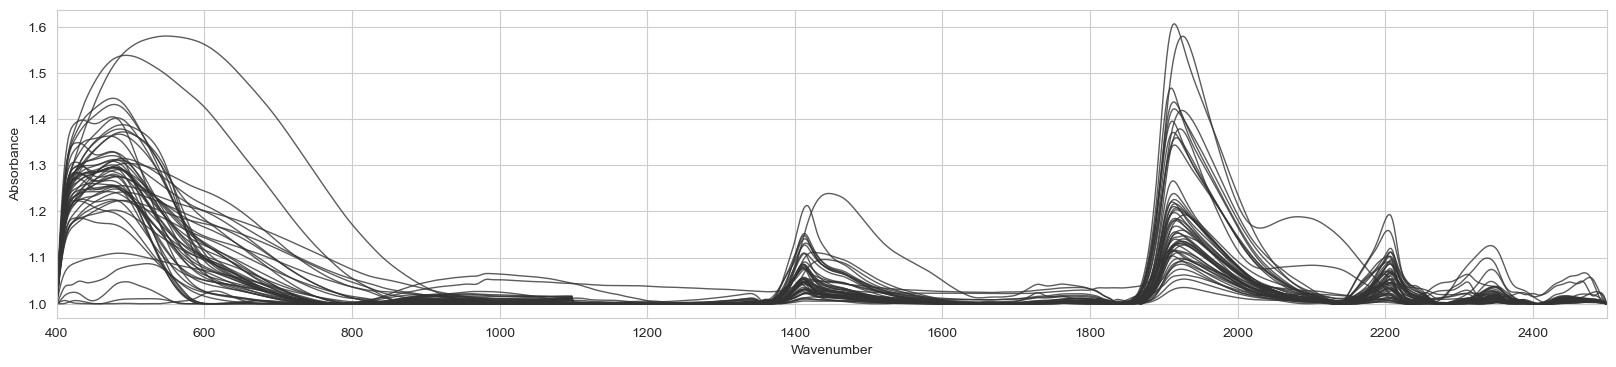

In [9]:
#|eval: false
pipe = Pipeline([('to_abs', ToAbsorbance()), 
                 ('cr', ContinuumRemoval(X_names))])
plot_spectra(pipe.fit_transform(X), X_names)

In [10]:
#|export
class SNV(BaseEstimator, TransformerMixin):
    """Creates scikit-learn SNV custom transformer"""
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        mean, std = np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)
        return (X - mean)/std

100%|██████████| 44489/44489 [00:15<00:00, 2790.77it/s]


<Figure size 640x480 with 0 Axes>

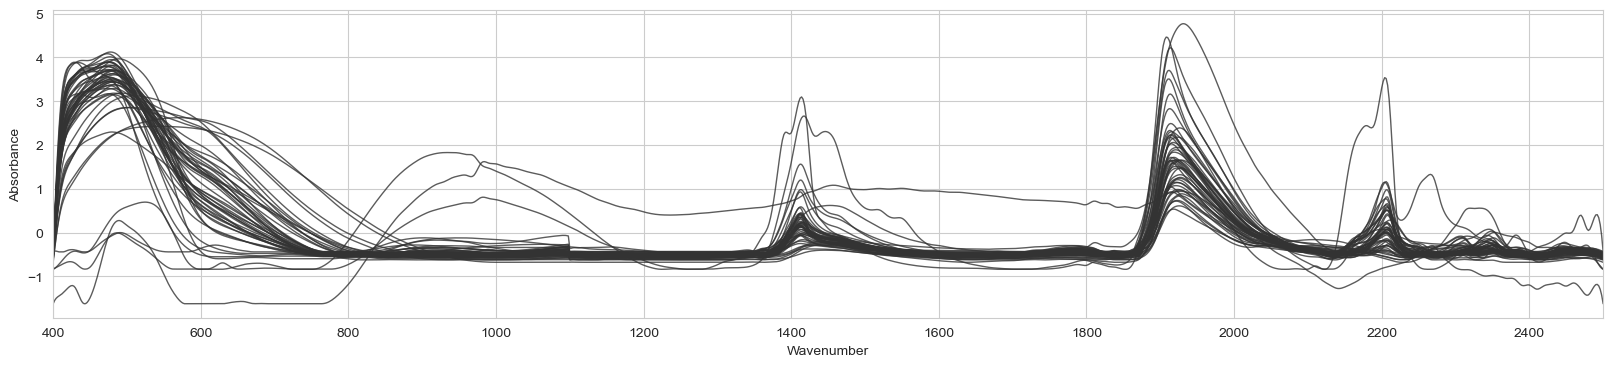

In [11]:
#|eval: false
pipe = Pipeline([('to_abs', ToAbsorbance()),
                 ('cr', ContinuumRemoval(X_names)),
                 ('snv', SNV())])
plot_spectra(pipe.fit_transform(X), X_names)

In [73]:
#|export
class Log1p(BaseEstimator, TransformerMixin):
    """Creates scikit-learn `np.log1p` target custom transformer"""
    def fit(self, y, X=None): return self
    def transform(self, y, X=None): return np.log1p(y)